Aim: Predict Rating from Review using basic and deep models

In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
#https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

## Preprocessing Function

Here is the process :
* Remove the non Letters
* Convert everything to lower case
* Remove stop words
* Stem the words

In [3]:
def review_to_wordlist( review, remove_stopwords=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()

    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer #PorterStemmer()
    for word in words:
        b.append(stemmer.stem(word))

    # 5. Return a list of words
    return(b)

## Import Datas

We import only 20000 lines of our total data in order to run the notebook faster

In [4]:
data_file = '../input/Amazon_Unlocked_Mobile.csv'

n = 413000  
s = 20000 
skip = sorted(random.sample(range(1,n),n-s))


data = pd.read_csv( data_file, delimiter = ",", skiprows = skip)

In [5]:
data.shape

(20840, 6)

In [6]:
data = data[data['Reviews'].isnull()==False]

In [7]:
train, test = train_test_split(data, test_size = 0.3)

## Labels Exploration

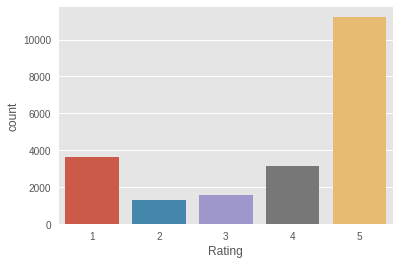

In [8]:
sns.countplot(data['Rating'])

Much More 5 than others ratings

### Apply Preprocessing

In [9]:
clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.'

## TFidf transformation

### TFidf

We will use tfidf transformation with ngrams between 1 and 4.

In [10]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 200000, ngram_range = ( 1, 4 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews)
train_features = vectorizer.transform(clean_train_reviews)

test_features = vectorizer.transform(clean_test_reviews)

### Select Best Features

We only select the best features for our prediction

In [11]:
fselect = SelectKBest(chi2 , k=10000)
train_features = fselect.fit_transform(train_features, train["Rating"])
test_features = fselect.transform(test_features)

## Modelling

### NBayes, RF, GBM, SGDClassifier ...

In [12]:
model1 = MultinomialNB(alpha=0.001)
model1.fit( train_features, train["Rating"] )

model2 = SGDClassifier(loss='modified_huber', n_iter=5, random_state=0, shuffle=True)
model2.fit( train_features, train["Rating"] )

model3 = RandomForestClassifier()
model3.fit( train_features, train["Rating"] )

model4 = GradientBoostingClassifier()
model4.fit( train_features, train["Rating"] )

pred_1 = model1.predict( test_features.toarray() )
pred_2 = model2.predict( test_features.toarray() )
pred_3 = model3.predict( test_features.toarray() )
pred_4 = model4.predict( test_features.toarray() )

### NBSVM

taken from https://github.com/lrei/nbsvm/blob/master/nbsvm2.py

In [13]:
class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


def main(train_file, test_file, ngram=(1, 3)):
    print('loading...')
    train = pd.read_csv(train_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    # to shuffle:
    #train.iloc[np.random.permutation(len(df))]

    test = pd.read_csv(test_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    print('vectorizing...')
    vect = CountVectorizer()
    classifier = NBSVM()

    # create pipeline
    clf = Pipeline([('vect', vect), ('nbsvm', classifier)])
    params = {
        'vect__token_pattern': r"\S+",
        'vect__ngram_range': ngram, 
        'vect__binary': True
    }
    clf.set_params(**params)

    #X_train = vect.fit_transform(train['text'])
    #X_test = vect.transform(test['text'])

    print('fitting...')
    clf.fit(train['text'], train['label'])

    print('classifying...')
    pred = clf.predict(test['text'])
   
    print('testing...')
    acc = accuracy_score(test['label'], pred)
    f1 = semeval_senti_f1(pred, test['label'])
    print('NBSVM: acc=%f, f1=%f' % (acc, f1))

In [14]:
model5 = NBSVM(C=0.01)
model5.fit( train_features, train["Rating"] )

pred_5 = model5.predict( test_features )

## Visualize Errors

### Classification Report

In [15]:
print(classification_report(test['Rating'], pred_2, target_names=['1','2','3','4','5']))

             precision    recall  f1-score   support

          1       0.66      0.78      0.72      1077
          2       0.45      0.12      0.19       391
          3       0.32      0.14      0.20       428
          4       0.41      0.15      0.22       980
          5       0.73      0.94      0.82      3376

avg / total       0.62      0.68      0.63      6252



### Confusion Matrix

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test['Rating'], pred_5)

Confusion matrix, without normalization
[[ 831   24   23   25  174]
 [ 186   48   20   27  110]
 [ 109   15   55   63  186]
 [  48    6   25  159  742]
 [  69    7   14   87 3199]]


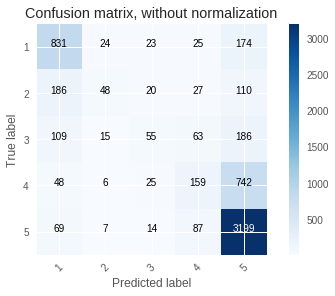

In [17]:
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'],
                      title='Confusion matrix, without normalization')

In [18]:
print('prediction 1 accuracy: ', accuracy_score(test['Rating'], pred_1))
print('prediction 2 accuracy: ', accuracy_score(test['Rating'], pred_2))
print('prediction 3 accuracy: ', accuracy_score(test['Rating'], pred_3))
print('prediction 4 accuracy: ', accuracy_score(test['Rating'], pred_4))
print('prediction 5 accuracy: ', accuracy_score(test['Rating'], pred_5))

prediction 1 accuracy:  0.656909788868
prediction 2 accuracy:  0.681861804223
prediction 3 accuracy:  0.656589891235
prediction 4 accuracy:  0.637236084453
prediction 5 accuracy:  0.686500319898


## Deep Learning

### MLP

A Multilayer Perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. An MLP consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. Except for the input nodes, each node is a neuron (or processing element) with a nonlinear activation function. (source Wikipedia)

They can be usefull but are not the best deep models to use with unstructured data as text.

We will apply the MLP on the Tfidf Matrix

In [19]:
batch_size = 32
nb_classes = 5

In [20]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 1000, ngram_range = ( 1, 3 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews)
train_features = vectorizer.transform(clean_train_reviews)

test_features = vectorizer.transform(clean_test_reviews)

In [21]:
X_train = train_features.toarray()
X_test = test_features.toarray()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(train['Rating']-1)
y_test = np.array(test['Rating']-1)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.mean(X_train)
X_train -= mean
X_test -= mean

input_dim = X_train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(256, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print("Training...")
model.fit(X_train, Y_train, nb_epoch=5, batch_size=16, validation_split=0.1, show_accuracy=True)

print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

X_train shape: (14587, 1000)
X_test shape: (6252, 1000)
Training...


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/models.py:847: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


TypeError: Unrecognized keyword arguments: {'show_accuracy': True}

In [22]:
print('prediction 6 accuracy: ', accuracy_score(test['Rating'], preds+1))

NameError: name 'preds' is not defined

### LSTM

The forward pass of a RNN is the same as the one of a MLP except that outputs from hidden layers are also used as inputs from the same layer. That means that the input from the hidden layer is both the outputs from the hidden layer one step back in time and the external input. So we have the equation:


\begin{equation} 
a_{h,t} = \sum_{i}{w_{i,h}*x_{i,t}} + \sum_{h'}{w_{h',h}*b_{h',t-1}} 
\end{equation} 


\begin{equation} 
b_{h,t} = \phi_{h}(a_{h,t}) 
\end{equation} 


where: 
* $x_{t,i} =$ value of input i at time t 
* $a_{t,j} =$ network input to unit j at time t 
* $b_{t,j}=$ output of activation of unit j at time t
* $w_{i,h} =$  weights of the network

Long Short Term Memory networks – usually just called LSTM – are a special kind of RNN, capable of learning long-term dependencies. (The idea behind those is to counter the vanishing problem of some basic RNN.)

Thus, LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In [23]:
max_features = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
maxlen = 80
batch_size = 32
nb_classes = 5

In [24]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=max_features)
tokenizer.fit_on_texts(train['Reviews'])
sequences_train = tokenizer.texts_to_sequences(train['Reviews'])
sequences_test = tokenizer.texts_to_sequences(test['Reviews'])

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [25]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (14587, 80)
X_test shape: (6252, 80)


The embedding layer in text mining is really important. Indeed, it is a way to map our text input into a space (a dictionary of dimension here 128). The layer is trained through iterations (epochs) to have a better weights for the dictionary that allow to minimize the global error of the network.

Skip-gram, CBOW, and GloVe (or any other word2vec variant) are pre-trained word embeddings which can be set as the weight of an embedding layer. If the weight of this layer (generally the first layer of the network) is not initialized by these pre-trained vectors, the model/network itself would assign random weights and will learn the embeddings (i.e. weights) on the fly.

Explanation summarized from :
https://github.com/fchollet/keras/issues/3110

In [26]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Build model...


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`


Train...


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/models.py:847: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 14587 samples, validate on 6252 samples
Epoch 1/1
6252/6252 [==============================] - 16s    
Test score: 0.300410506802
Test accuracy: 0.880870125077
Generating test predictions...


In [27]:
print('prediction 7 accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction 7 accuracy:  0.672744721689


add epochs and reviews to be more accurate with LSTM

### CNN

Explanation from: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/


There are four main operations in the ConvNet :

Convolution
Non Linearity (ReLU)
Pooling or Sub Sampling
Classification (Fully Connected Layer)

Convolution consists in applying different filters (here we chose to use 250 filters) on our input (here text). The main goal of the convolution step is to extract features from the input.

The different filters allow to apply different convolutions (mathematical convolutions) on our input. As a result we obtain N (N: number of filters) convolved input after the application of our convolved layer.

In order to add non linearity , we use Relu after the convolution layer. 

After we have pooling. Spatial Pooling reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum etc.

The last step is the same as the MLP

In [28]:
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

In [29]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))

def max_1d(X):
    return K.max(X, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid")`


In [30]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Train...


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/models.py:847: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 14587 samples, validate on 6252 samples
Epoch 1/1
6176/6252 [============================>.] - ETA: 0sTest score: 0.290247488474
Test accuracy: 0.883269358848
Generating test predictions...


In [31]:
print('prediction 8 accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction 8 accuracy:  0.678182981446
